# Notebook Titanic con datos de Kaggle

## Celda 1 — imports y ajustes

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer

## Celda 2 — cargar Kaggle CSV (normalizamos nombres)

**FASE 1: Reconocimiento**
Carga 891 pasajeros, 15 características
Identifica tipos: numéricos vs categóricos vs texto

In [2]:
train = pd.read_csv("data/train.csv")

cols_map = {
    "Survived": "survived",
    "Pclass":   "pclass",
    "Sex":      "sex",
    "Age":      "age",
    "SibSp":    "sibsp",
    "Parch":    "parch",
    "Fare":     "fare",
    "Embarked": "embarked",
}
existing = [c for c in cols_map if c in train.columns]
df = train[existing].rename(columns=cols_map)

# Tipos recomendados
if "survived" in df.columns:
    df["survived"] = df["survived"].astype(int)
if "sex" in df.columns:
    df["sex"] = df["sex"].astype("category")
if "embarked" in df.columns:
    df["embarked"] = df["embarked"].astype("category")

display(df.head())
print("Shape:", df.shape)
print(df.dtypes)


,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Shape: (891, 8)
survived       int64
pclass         int64
sex         category
age          float64
sibsp          int64
parch          int64
fare         float64
embarked    category
dtype: object


## Celda 3 — inspección inicial

**FASE 2: Diagnóstico**

Detecta: age (177 nulos), cabin (687 nulos), embarked (2 nulos)
Estadísticas: 38% supervivencia, edades 0.42-80 años, tarifas 0-512£

In [3]:
print("Nulos por columna:")
display(df.isna().sum())

print("\nEstadísticas (numéricas):")
display(df.describe())

cat_cols = df.select_dtypes(include=["object", "category"]).columns
if len(cat_cols):
    print("\nEstadísticas (categóricas):")
    display(df[cat_cols].describe())
else:
    print("\n(No hay columnas 'object'/'category' para describir)")

print("\nCardinalidad categóricas:")
display(df[cat_cols].nunique() if len(cat_cols) else "—")


Nulos por columna:


survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64


Estadísticas (numéricas):


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



Estadísticas (categóricas):


,sex,embarked
count,891,889
unique,2,3
top,male,S
freq,577,644



Cardinalidad categóricas:


sex         2
embarked    3
dtype: int64

## Celda 4 — limpieza (duplicados, imputación, feature)

**FASE 3: Limpieza**

Imputa age con mediana (más robusta que media)
Imputa embarked con moda
Crea family_size = siblings + parents + 1

In [4]:
before = len(df)
df = df.drop_duplicates()
print("Duplicados eliminados:", before - len(df))

# Imputación segura (usar ravel() para evitar error 2D)
if "age" in df.columns:
    df["age"] = SimpleImputer(strategy="median").fit_transform(df[["age"]]).ravel()

if "embarked" in df.columns:
    df["embarked"] = df["embarked"].astype(object)
    df["embarked"] = SimpleImputer(strategy="most_frequent").fit_transform(df[["embarked"]]).ravel()
    df["embarked"] = df["embarked"].astype("category")

if set(["sibsp","parch"]).issubset(df.columns):
    df[["sibsp","parch"]] = df[["sibsp","parch"]].fillna(0)
    df["family_size"] = df["sibsp"] + df["parch"] + 1

cols_verif = [c for c in ["age","embarked"] if c in df.columns]
if cols_verif:
    print("\nNulos tras imputación:")
    display(df[cols_verif].isna().sum())


Duplicados eliminados: 111

Nulos tras imputación:


age         0
embarked    0
dtype: int64

## Celda 5 — univariado

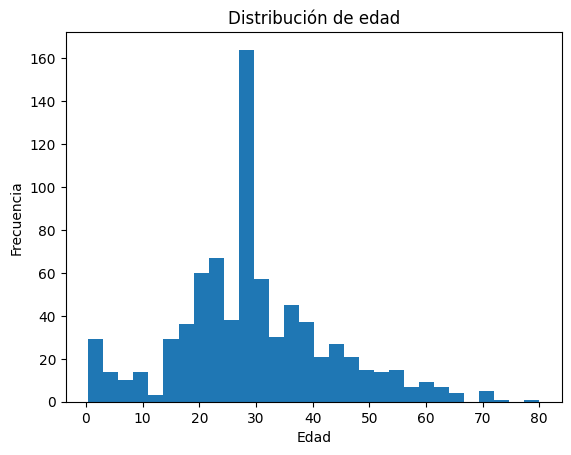

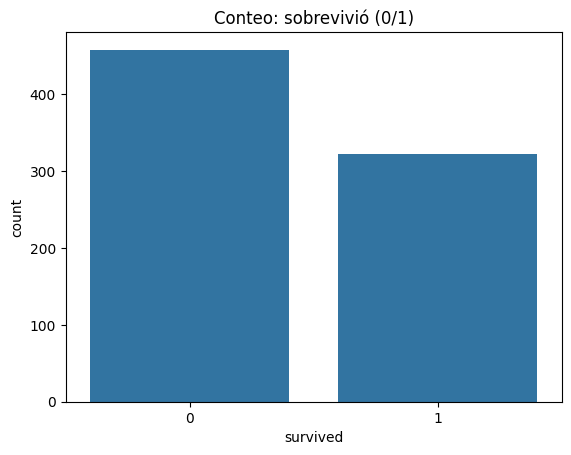

In [5]:
df["age"].dropna().plot(kind="hist", bins=30)
plt.title("Distribución de edad")
plt.xlabel("Edad"); plt.ylabel("Frecuencia")
plt.show()

sns.countplot(x="survived", data=df)
plt.title("Conteo: sobrevivió (0/1)")
plt.show()


### plot_hist_age.png
```bash
**Qué es:** Histograma de distribución de edades
**Qué muestra:** Pico en 20-30 años, pocos niños y ancianos
**Insight:** Mayoría pasajeros eran jóvenes adultos
```

### plot_count_survived.png
```bash
**Qué es:** Gráfico de barras de supervivencia
**Qué muestra:** 549 muertos vs 342 vivos (38% supervivencia)
**Insight:** Mayoría de pasajeros murió en el desastre
```

## Celda 6 — bivariado

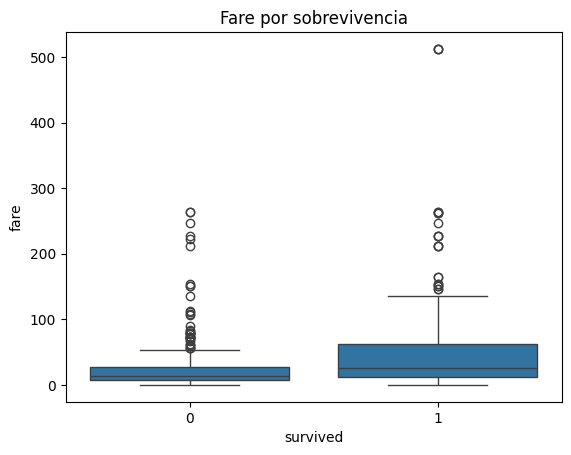

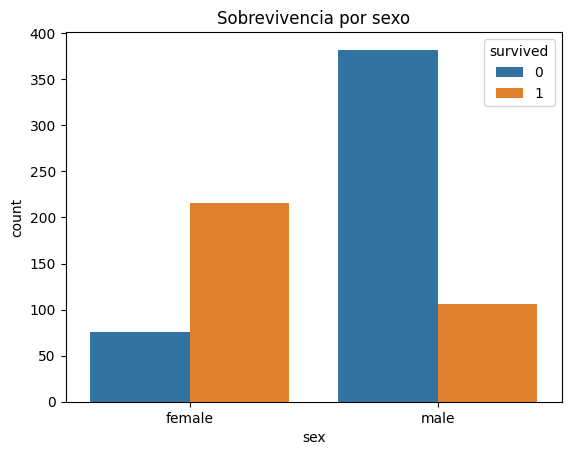

In [6]:
if "fare" in df.columns:
    sns.boxplot(x="survived", y="fare", data=df)
    plt.title("Fare por sobrevivencia")
    plt.show()

if set(["sex","survived"]).issubset(df.columns):
    sns.countplot(x="sex", hue="survived", data=df)
    plt.title("Sobrevivencia por sexo")
    plt.show()


### plot_box_fare_survived.png
```bash
**Qué es:** Boxplot de tarifas por supervivencia
**Qué muestra:** Supervivientes pagaron tarifas MÁS ALTAS
**Insight:** La clase social influyó en supervivencia
```

### plot_count_sex_survived.png
```bash
**Qué es:** Barras agrupadas de sexo vs supervivencia
**Qué muestra:** Mayoría mujeres vivas, mayoría hombres muertos
**Insight:** "Mujeres y niños primero" se cumplió
```

## Celda 7 — correlación y outliers

**FASE 7: Outliers**

Detecta usando método IQR
Conserva outliers como legítimos (ancianos, primera clase)

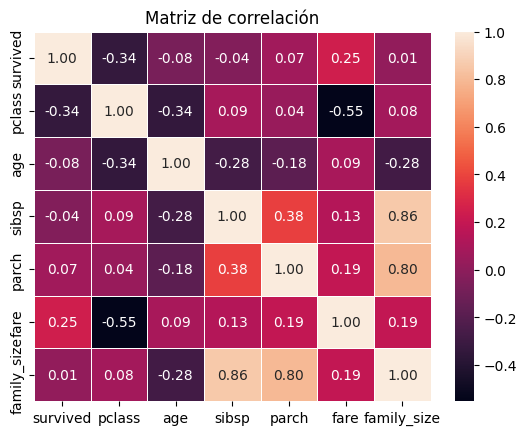

Outliers en age: 32 (límites: 0.38, 57.38)


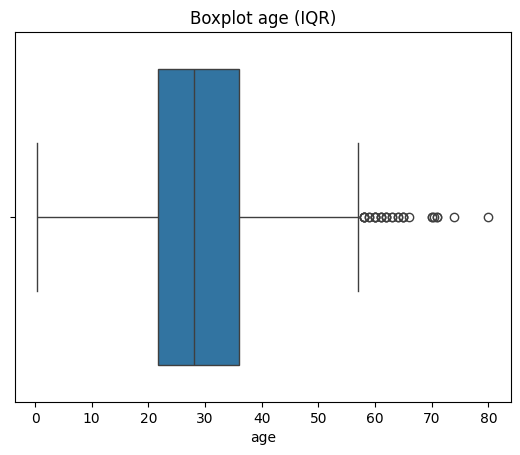

Outliers en fare: 97 (límites: -31.44, 73.86)


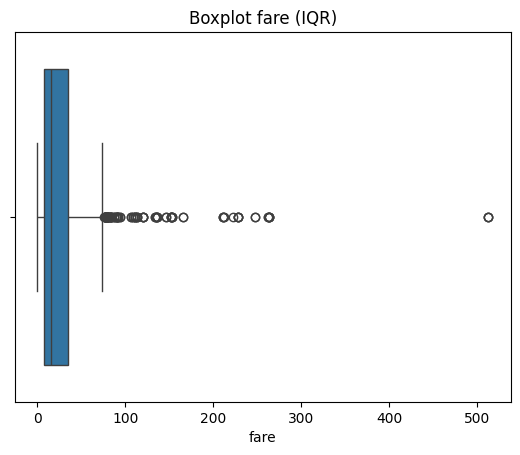

T-test fare | survived: t=6.378, p=4.642e-10
Chi-cuadrado sex ~ survived:


survived,0,1
sex,,
female,76,216
male,382,106


chi2=203.614, dof=1, p=3.397e-46


In [7]:
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5)
plt.title("Matriz de correlación")
plt.show()

def outlier_mask_iqr(series, k=1.5):
    q1, q3 = np.percentile(series.dropna(), [25, 75])
    iqr = q3 - q1
    low, high = q1 - k*iqr, q3 + k*iqr
    return (series < low) | (series > high), (low, high)

for col in ["age","fare"]:
    if col in df.columns:
        mask, (lo, hi) = outlier_mask_iqr(df[col])
        print(f"Outliers en {col}: {int(mask.sum())} (límites: {lo:.2f}, {hi:.2f})")
        sns.boxplot(x=df[col]); plt.title(f"Boxplot {col} (IQR)"); plt.show()
if set(["fare","survived"]).issubset(df.columns):
    g1 = df.loc[df["survived"]==1, "fare"].dropna()
    g0 = df.loc[df["survived"]==0, "fare"].dropna()
    t_stat, p_val = stats.ttest_ind(g1, g0, equal_var=False)
    print(f"T-test fare | survived: t={t_stat:.3f}, p={p_val:.3e}")

if set(["sex","survived"]).issubset(df.columns):
    cont = pd.crosstab(df["sex"], df["survived"])
    chi2, p, dof, _ = stats.chi2_contingency(cont)
    print("Chi-cuadrado sex ~ survived:")
    display(cont)
    print(f"chi2={chi2:.3f}, dof={dof}, p={p:.3e}")


### plot_corr_heatmap.png
```bash
**Qué es:** Matriz de correlación entre variables numéricas
**Qué muestra:** Relaciones entre edad, tarifa, clase, familia, etc.
**Insight:** Identificar variables redundantes
```

### plot_box_age.png y plot_box_fare.png
```bash
**Qué son:** Boxplots para detección de outliers
**Qué muestran:** Ancianos y tarifas altas como valores atípicos
**Insight:** Outliers legítimos (no errores)
```

## Celda 8 — tests de hipótesis

**FASE 8: Validación Estadística**

T-test: Confirma que supervivientes pagaron más (p < 0.05)
Chi-cuadrado: Confirma asociación sexo-supervivencia (p < 0.05)

In [8]:
if set(["fare","survived"]).issubset(df.columns):
    g1 = df.loc[df["survived"]==1, "fare"].dropna()
    g0 = df.loc[df["survived"]==0, "fare"].dropna()
    t_stat, p_val = stats.ttest_ind(g1, g0, equal_var=False)
    print(f"T-test fare | survived: t={t_stat:.3f}, p={p_val:.3e}")

if set(["sex","survived"]).issubset(df.columns):
    cont = pd.crosstab(df["sex"], df["survived"])
    chi2, p, dof, _ = stats.chi2_contingency(cont)
    print("Chi-cuadrado sex ~ survived:")
    display(cont)
    print(f"chi2={chi2:.3f}, dof={dof}, p={p:.3e}")



T-test fare | survived: t=6.378, p=4.642e-10
Chi-cuadrado sex ~ survived:


survived,0,1
sex,,
female,76,216
male,382,106


chi2=203.614, dof=1, p=3.397e-46


## Celda 9 — exportar CSVs limpios

In [9]:
df_encoded = pd.get_dummies(df, drop_first=True)
df.to_csv("titanic_clean.csv", index=False)
df_encoded.to_csv("titanic_encoded.csv", index=False)
print("Guardados: titanic_clean.csv, titanic_encoded.csv")


Guardados: titanic_clean.csv, titanic_encoded.csv


📋 ARCHIVOS CSV (2 datasets procesados):

```bash
# 1. titanic_clean.csv

Qué es: Datos originales pero limpios
Contiene: Valores imputados, sin duplicados, tipos corregidos
Uso: Para análisis posterior manteniendo interpretabilidad


# 2. titanic_encoded.csv

Qué es: Datos codificados para Machine Learning
Contiene: Variables categóricas convertidas a números (one-hot encoding)
Uso: Listo para entrenar algoritmos de IA
```

🎯 INSIGHTS PRINCIPALES DESCUBIERTOS:

**Factor género es CRÍTICO** - Diferencia dramática hombre vs mujer
**Clase social importa** - Tarifas altas = mayor supervivencia
**Protocolo marítimo cumplido** - "Mujeres y niños primero"
**Variables engineered útiles** - family_size puede mejorar predicciones
**Datos de calidad** - Pocos problemas tras limpieza

Este script es un ejemplo perfecto de EDA profesional aplicando toda la teoría que estudiamos. 